In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns
sns.set_style('dark')
import torch
import glob
import os
import sys
from scipy import linalg

cwd = os.getcwd()
dir = os.path.dirname(cwd)
sys.path.append(dir)

In [36]:
folder = 'Results'
subfolder = 'four_state_mdp_results'
second_subfolder = 'large_gammas'
pattern = "values_4_state_monot_0*_*.npy"

file_list = glob.glob(os.path.join(dir, folder, subfolder, second_subfolder, pattern))

data_list = [np.load(os.path.join(dir, folder, subfolder, second_subfolder, file)) for file in file_list]

# Sort the file list by extracting the integer part from the filenames
file_list.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Load and process the files as before
data_list = [np.load(os.path.join(dir, folder, subfolder, second_subfolder, file)) for file in file_list]

# shape : (num_gammas, num_states, num_sensitivities)
Q_gamma = np.zeros((len(data_list), data_list[0].shape[0], data_list[0].shape[-1]))
i = 0
for file, data in zip(file_list, data_list):
    print(f"Loaded {file} with shape {data.shape}")
    Q_gamma[i, :, :] = data[:, 0, 0, :]
    i += 1

Loaded /Users/abelrassat/Desktop/NSC/NSC2/FoRL/DRL_Project/side_tests/distrl_proj/Results/four_state_mdp_results/large_gammas/values_4_state_monot_0.9900_0.npy with shape (4, 1, 1, 500)


In [31]:
print(Q_gamma.shape)
Q_gamma2 = Q_gamma[0, 0, :]
#Z = Q_gamma2[:-6] - Q_gamma2[1:-5]
Z = Q_gamma2[:-2] - Q_gamma2[1:-1]

(1, 4, 500)


In [32]:
from config import Config
from envs.four_state_mdp import Simple4MDP
env = Simple4MDP()
# assuming configs for the Laplace Code are same as when data was generated 
C = Config(env)

num_sensitivities = C.num_sensitivities
rmin = C.rmin
rmax = C.rmax
num_gamma = C.num_gamma
sensitivity_step = (rmax - rmin) / num_sensitivities
sensitivities = torch.arange(rmin, rmax, sensitivity_step)
middle_sensitivities = torch.tensor([torch.true_divide(sensitivities[i] + sensitivities[i+1], 2) for i in range(sensitivities.shape[0]-1)])   
taus = torch.linspace(0.01,3,num_gamma) # as in implementation from Pablo Tano
gammas = torch.exp(-1/taus)

In [6]:
Q_gamma2=Q_gamma[4:-1,0,:]
Z=Q_gamma2[:,0:-2]-Q_gamma2[:,1:-1]

X,Y=np.meshgrid(sensitivities[0:-2],gammas[4:-1])

for h in range(0,num_sensitivities-2):
    Z[:,h]=savgol_filter(Z[:,h], 1, 1)  

    
fig = plt.figure(figsize=[5,3],dpi=150)
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='summer'
                       , edgecolor='none',alpha=1)
ax.view_init(60, -45)
ax.set_zlim(0,0.15)
ax.grid(b=None)
plt.yticks([0,0.5,1])
#plt.xticks([-2,-1,0,1,2])
plt.xticks([2, 3, 7, 8])
ax.set_zlabel('Convergence value')
ax.set_ylabel('Temporal Discount')
ax.set_xlabel('Reward')
plt.show()

ValueError: polyorder must be less than window_length.

/var/folders/xm/tw531zn55y31wj5l8fypl1tc0000gn/T/ipykernel_69387/2049109326.py:6: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x,c,a: 1/(1 + np.exp(-a*(x-c))) #reward sensitivities


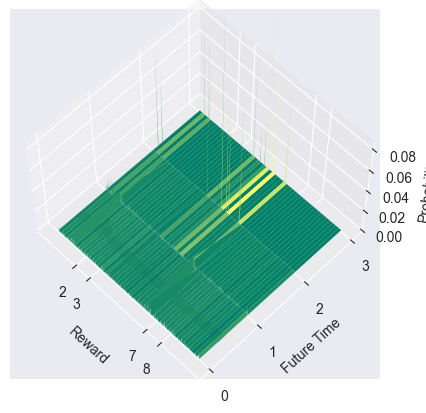

In [10]:
alpha_reg=0.2 #Regularization parameter

K=4 #Temporal horizon
delta_t=1 #Temporal resolution
width=13 #width of the reward sensitivities
sigmoid = lambda x,c,a: 1/(1 + np.exp(-a*(x-c))) #reward sensitivities

#define matrix F:
F=np.zeros((len(gammas),K))
for i_g in range(0,len(gammas)):
    for i_t in range(0,K):
        F[i_g,i_t]=gammas[i_g]**(i_t*delta_t)

        
U, lam, V = linalg.svd(F) #SVD decomposition of F

#set up gamma-space:
Q_gamma2=Q_gamma[:,0,:]
Z=Q_gamma2[:,0:-2]-Q_gamma2[:,1:-1]


#smooth gamma-space (it might not be necessary, it helps if the input is *very* noisy):
for h in range(0,num_sensitivities-2):
    Z[:,h]=savgol_filter(Z[:,h], 5, 1)

#Linearly recover tau-space from eigenspace of F:
tau_space=np.zeros((K,num_sensitivities-2))
for h in range(0,num_sensitivities-2):
    term=np.zeros((1,K))
    for i in range(0,len(lam)):
        fi=lam[i]**2/(alpha_reg**2+lam[i]**2)
        new=fi*(((U[:,i]@Z[:,h])*V[i,:] )/lam[i])
        term=term+new
    tau_space[:,h]=term

    
#smooth gamma-space (it might not be necessary, use for a smoother visualization):
for h in range(0,num_sensitivities-2):
    tau_space[:,h]=savgol_filter(tau_space[:,h], 2, 1)


#Normalization (it is not really necessary for this very short temporal horizon T=4):
tau_space[tau_space<0]=0 #make all probabilities positive
for i in range(0,len(tau_space)): #normalize
    if np.nansum(tau_space[i,:])>0.0:
        tau_space[i,:]=tau_space[i,:]/np.nansum(tau_space[i,:])
        


#Thin black lines that indicate true (smoothed) reward probability in tau-space of Fig.3:
i_t=0
P_r=np.nan*np.zeros((len(taus)-1,num_sensitivities+1))
for tau in taus[0:-2]:
    i_t=i_t+1
    for n in range(1,num_sensitivities):
        if tau<1.6:
            R=0.5*(sigmoid(-2,sensitivities[n],width)+sigmoid(2,sensitivities[n],width));
        elif tau>1.6:
            R=0.5*(sigmoid(-1,sensitivities[n],width)+sigmoid(1,sensitivities[n],width));
        P_r[i_t,n]=R
P_r=P_r[:,0:-1]-P_r[:,1:]


#Plot figure
plt.close(); fig=plt.figure()
plt.clf()
ax = fig.add_subplot(projection='3d')
X,Y=np.meshgrid(sensitivities[0:-2],delta_t*np.linspace(0,K-1,K)) #grid to plot

surf = ax.plot_surface(X, Y, tau_space, cmap='summer'
                           , edgecolor='none',alpha=1)

[X1,Y1]=np.meshgrid(sensitivities[0:-1],taus[3:5]-0.12);
Z1=P_r[3:5,0:-1];
surf = ax.plot_surface(X1, Y1, Z1, color=[0,0,0]
                           , edgecolor='none',alpha=0.4)

[X1,Y1]=np.meshgrid(sensitivities[0:-1],taus[27:29]+0.18);
Z1=P_r[27:29,0:-1]*0.95;
surf = ax.plot_surface(X1, Y1, Z1, color=[0,0,0]
                           , edgecolor='none',alpha=0.4)

[X1,Y1]=np.meshgrid(sensitivities[0:-1],taus[57:59]+0.25);
Z1=P_r[57:59,0:-1]*1;
surf = ax.plot_surface(X1, Y1, Z1, color=[0,0,0]
                           , edgecolor='none',alpha=0.4)

[X1,Y1]=np.meshgrid(sensitivities[0:-1],taus[57:59]+1.25);
Z1=P_r[57:59,0:-1]*1;
surf = ax.plot_surface(X1, Y1, Z1, color=[0,0,0]
                           , edgecolor='none',alpha=0.4)


ax.grid(b=None)

ax.view_init(60, -45)
plt.yticks([0,1,2,3])
#plt.xticks([-2,-1,0,1,2])
plt.xticks([2, 3, 7, 8])
ax.set_zlim(0,0.085)
ax.set_zlabel('Probability')
ax.set_ylabel('Future Time')
ax.set_xlabel('Reward')
fig.canvas.draw_idle()

In [9]:
values_4_state = np.load("values_4_state_5000ep_500.npy")
#values_4_state = np.load("values_4_state_1000ep_500.npy")
#values_4_state = np.load("values_4_state_5000ep_100.npy")
#values_4_state = np.load("values_4_state_5000ep_500_2sharp.npy")
#values_4_state = np.load("values_4_state_1000ep_500_1-2sharp.npy")
#values_4_state = np.load("values_4_state.npy")

pattern = "values_4_state_monot_0*_*.npy"
file_list = glob.glob(pattern)
data_list = [np.load(file) for file in file_list]

# Sort the file list by extracting the integer part from the filenames
file_list.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Load and process the files as before
data_list = [np.load(file) for file in file_list]

for file, data in zip(file_list, data_list):
    print(f"Loaded {file} with shape {data.shape}")\
# for file, data in zip(file_list, data_list):
#     print(f"Loaded {file} with shape {data.shape}")

Loaded values_4_state_monot_0.0100_0.npy with shape (4, 1, 1, 500)
Loaded values_4_state_monot_0.9900_0.npy with shape (4, 1, 1, 500)
Loaded values_4_state_monot_0.9801_1.npy with shape (4, 1, 1, 500)
Loaded values_4_state_monot_0.9900_2.npy with shape (4, 1, 1, 500)


In [13]:
data_diff_list = []
for i, data in enumerate(data_list):
    data_diff_list.append(data[0, 0, 0, :-1] - data[0, 0, 0, 1:])

In [14]:
print(values_4_state.shape)

# state 0
diff_0 = values_4_state[0, 0, 0, :-1] - values_4_state[0, 0, 0, 1:]
# state 1
diff_1 = values_4_state[1, 0, 0, :-1] - values_4_state[1, 0, 0, 1:]
# state 2
diff_2 = values_4_state[2, 0, 0, :-1] - values_4_state[2, 0, 0, 1:]
# state 3
diff_2 = values_4_state[2, 0, 0, :-1] - values_4_state[2, 0, 0, 1:]

#print(diff_0.shape, diff_0)
#print(type(diff_0))

NameError: name 'values_4_state' is not defined

498
(498,) torch.Size([499])


Text(0.5, 1.0, 'Monot - one more layer - Original rewards, Sharpness=50, num_episodes=2000, num_sensitivities=500, support_range=[-3,3]')

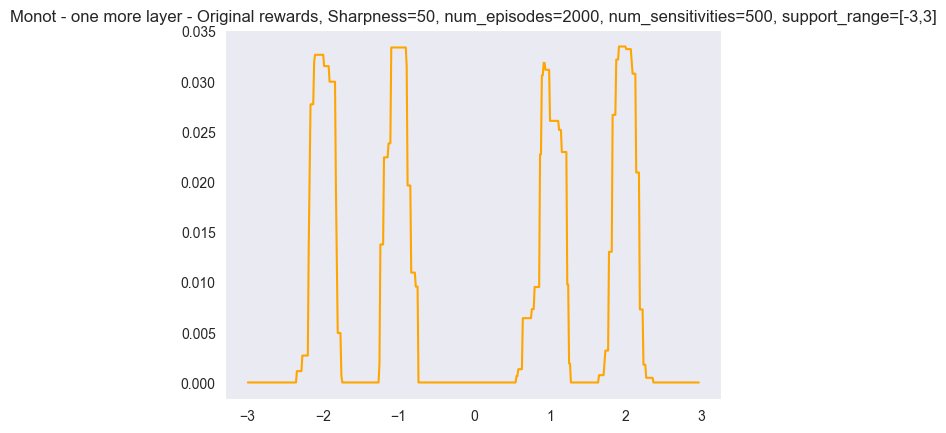

In [34]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 30, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities[:-1], smoothed_diff_0, color="orange", label="state = 0")
plt.title("Monot - one more layer - Original rewards, Sharpness=50, num_episodes=2000, num_sensitivities=500, support_range=[-3,3]")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

498
(498,) torch.Size([499])


Text(0.5, 1.0, 'Monot - one more layer - Original rewards, Sharpness=50, num_episodes=2000, num_sensitivities=500, support_range=[-3,3]')

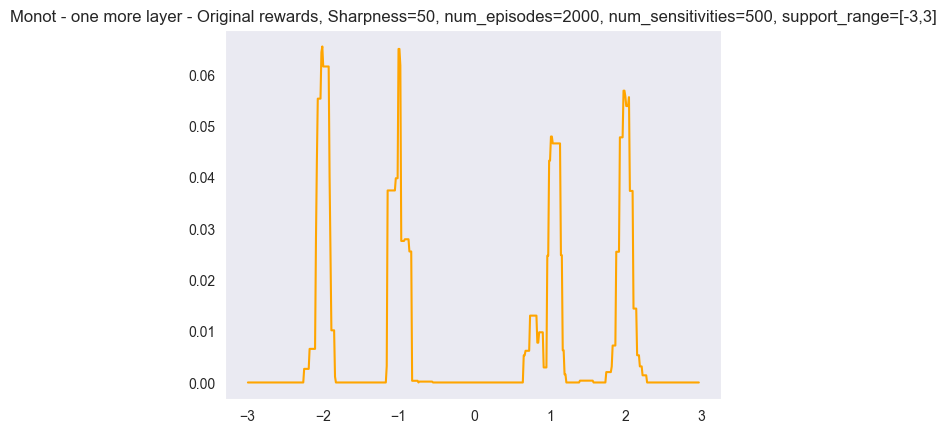

In [15]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 15, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities[:-1], smoothed_diff_0, color="orange", label="state = 0")
plt.title("Monot - one more layer - Original rewards, Sharpness=50, num_episodes=2000, num_sensitivities=500, support_range=[-3,3]")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

498
(498,) torch.Size([499])


Text(0.5, 1.0, 'Monot - one more layer, Sharpness=50, num_episodes=2000, num_sensitivities=500, support_range=[1, 9]')

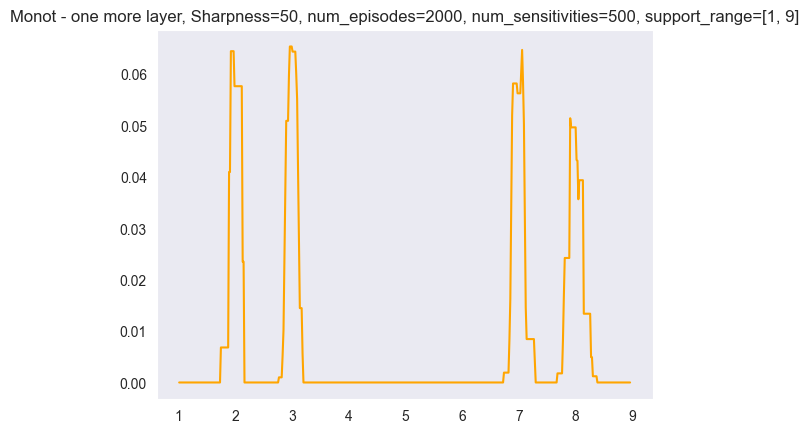

In [21]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 15, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities[:-1], smoothed_diff_0, color="orange", label="state = 0")
plt.title("Monot - one more layer, Sharpness=50, num_episodes=2000, num_sensitivities=500, support_range=[1, 9]")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

498
(498,) torch.Size([499])


Text(0.5, 1.0, 'Monot, Sharpness=50, num_episodes=5000, num_sensitivities=500, support_range=[1, 9]')

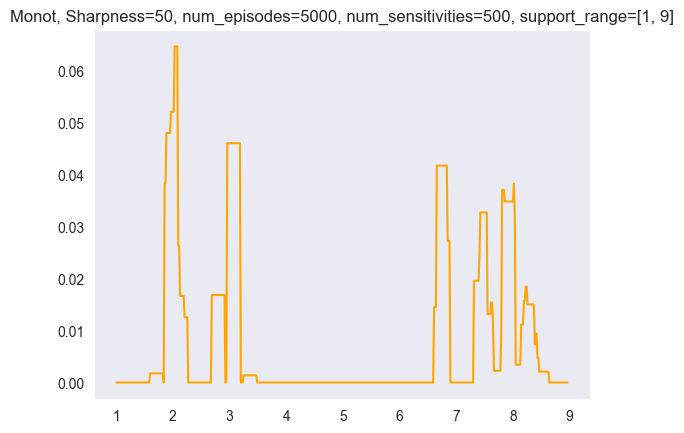

In [16]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 15, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities[:-1], smoothed_diff_0, color="orange", label="state = 0")
plt.title("Monot, Sharpness=50, num_episodes=5000, num_sensitivities=500, support_range=[1, 9]")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

498
(498,) torch.Size([499])


Text(0.5, 1.0, 'Two more layers, Sharpness=50, num_episodes=5000, num_sensitivities=500, support_range=[1, 9]')

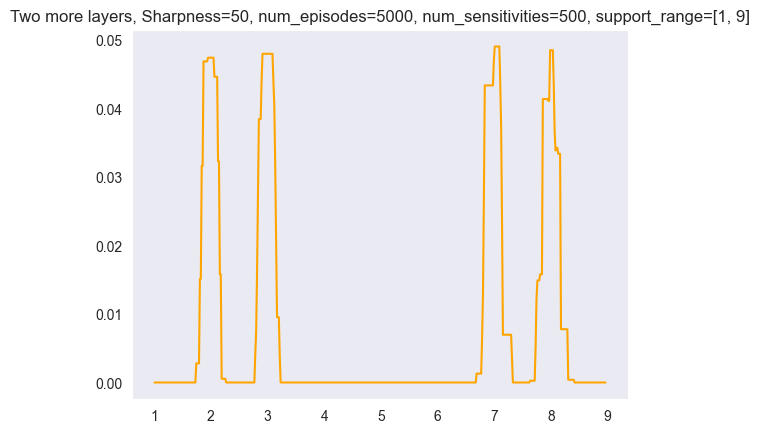

In [10]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 20, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities[:-1], smoothed_diff_0, color="orange", label="state = 0")
plt.title("Two more layers, Sharpness=50, num_episodes=5000, num_sensitivities=500, support_range=[1, 9]")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

498
(498,) torch.Size([499])


Text(0.5, 1.0, 'Sharpness=50, num_episodes=5000, num_sensitivities=500, support_range=[1, 9]')

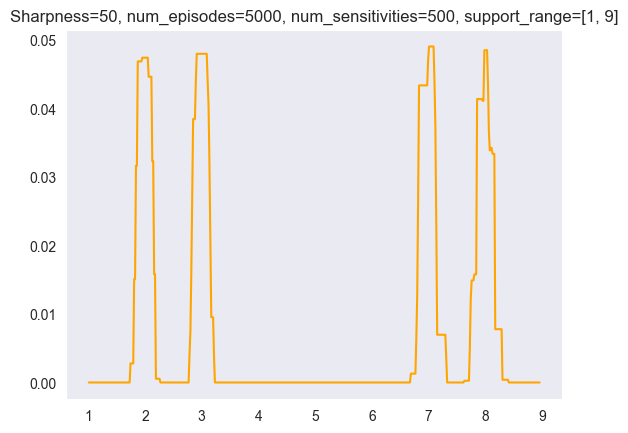

In [9]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 20, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities[:-1], smoothed_diff_0, color="orange", label="state = 0")
plt.title("Sharpness=50, num_episodes=5000, num_sensitivities=500, support_range=[1, 9]")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

998
(998,) torch.Size([999])


Text(0.5, 1.0, 'Sharpness=100, num_episodes=5000, num_sensitivities=1000, support_range=[1, 9]')

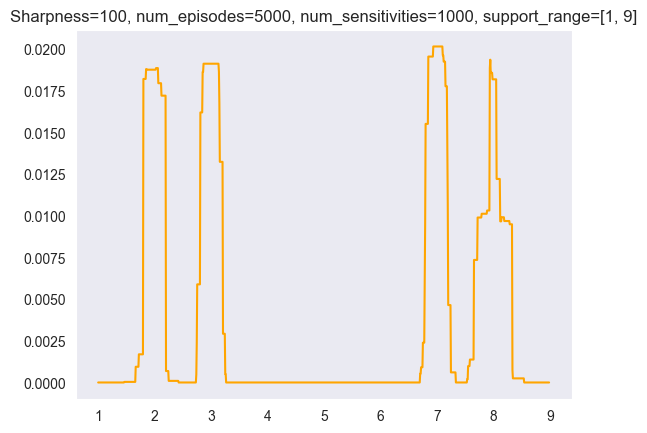

In [16]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 50, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities[:-1], smoothed_diff_0, color="orange", label="state = 0")
plt.title("Sharpness=100, num_episodes=5000, num_sensitivities=1000, support_range=[1, 9]")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

998
(998,) torch.Size([999])


Text(0.5, 1.0, 'Sharpness=50, num_episodes=5000, num_sensitivities=1000, support_range=[-2, 12]')

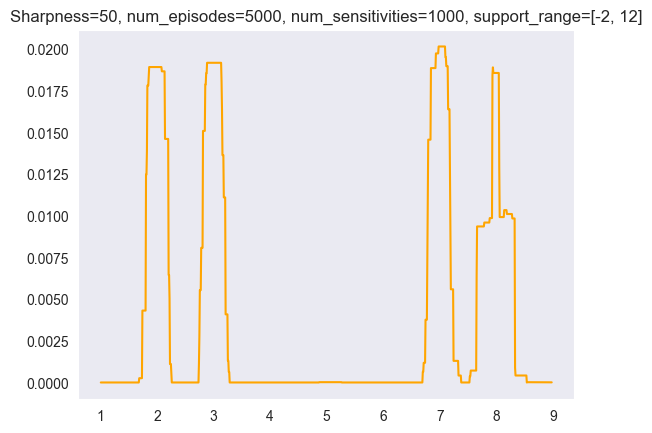

In [8]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 50, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities[:-1], smoothed_diff_0, color="orange", label="state = 0")
plt.title("Sharpness=50, num_episodes=5000, num_sensitivities=1000, support_range=[1, 9]")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

248
(248,) torch.Size([249])


Text(0.5, 1.0, 'Sharpness=60, num_episodes=5000, num_sensitivities=250')

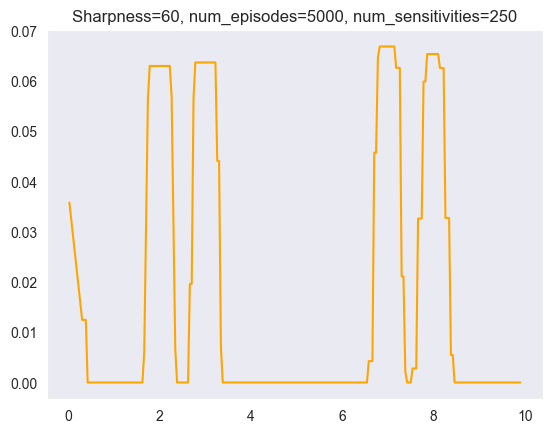

In [13]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 15, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities[:-1], smoothed_diff_0, color="orange", label="state = 0")
plt.title("Sharpness=60, num_episodes=5000, num_sensitivities=250")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

248
(248,) torch.Size([249])


Text(0.5, 1.0, 'Sharpness=30, num_episodes=5000, num_sensitivities=250')

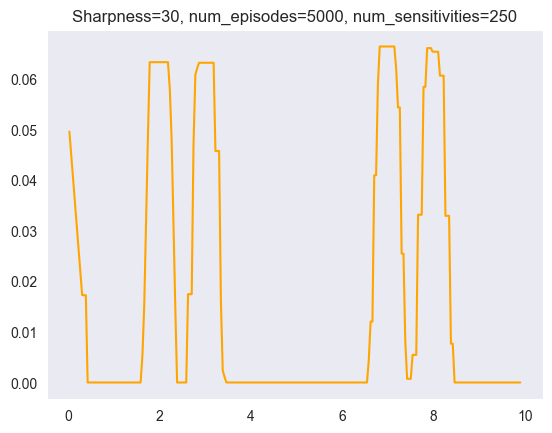

In [6]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 15, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities[:-1], smoothed_diff_0, color="orange", label="state = 0")
plt.title("Sharpness=30, num_episodes=5000, num_sensitivities=250")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

998
(998,) torch.Size([999])


Text(0.5, 1.0, 'Sharpness=60, num_episodes=5000, num_sensitivities=1000')

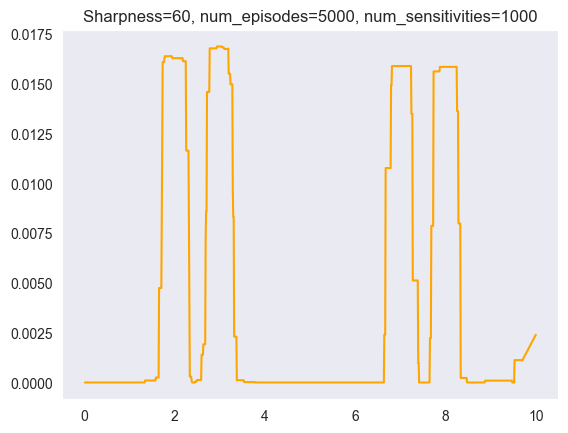

In [55]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 60, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities[:-1], smoothed_diff_0, color="orange", label="state = 0")
plt.title("Sharpness=60, num_episodes=5000, num_sensitivities=1000")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

994
(994,) torch.Size([999])


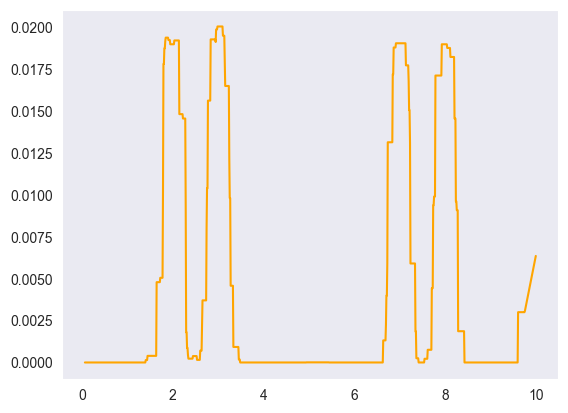

In [42]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 50, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities[:-5], smoothed_diff_0, color="orange", label="state = 0")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

994
(994,) torch.Size([999])


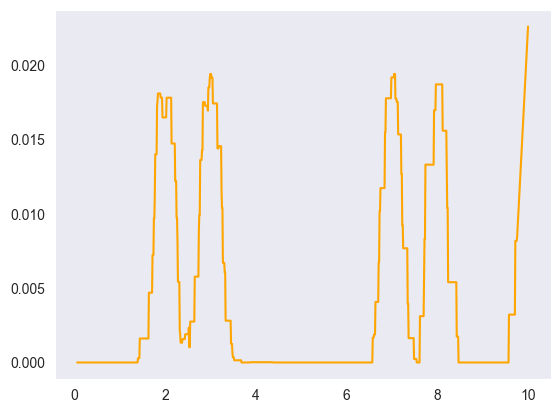

In [38]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 50, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities[:-5], smoothed_diff_0, color="orange", label="state = 0")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

999
(999,) torch.Size([999])


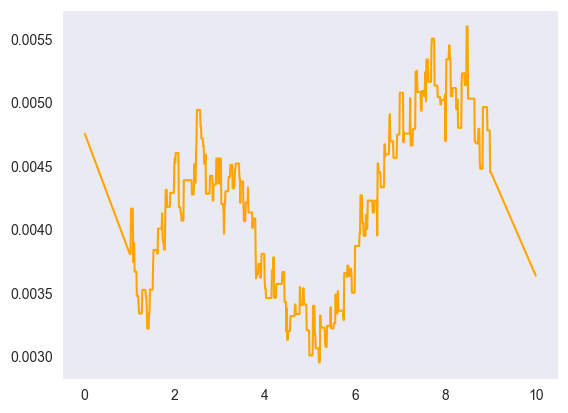

In [24]:
# Define window size
from scipy.signal import savgol_filter

window_size = 150
kernel = np.ones(window_size) / window_size
Z_large_gam = Z
print(len(Z_large_gam))
smoothed_diff_0=savgol_filter(Z_large_gam, 200, 1)  
#smoothed_diff_0 = np.convolve(Z_large_gam, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities, smoothed_diff_0, color="orange", label="state = 0")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

499
(499,) torch.Size([499])


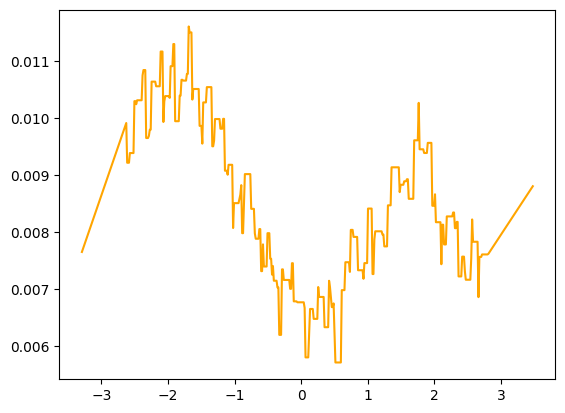

In [23]:
# Define window size
from scipy.signal import savgol_filter

window_size = 120
kernel = np.ones(window_size) / window_size
print(len(diff_0))
smoothed_diff_0=savgol_filter(diff_0, 100, 1)  
#smoothed_diff_0 = np.convolve(data_diff_list[-1], kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities, smoothed_diff_0, color="orange", label="state = 0")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rewards_arr = np.load("reward_laplace.npy")
losses_arr = np.load("losses_laplace.npy", allow_pickle=True)
losses_arr[losses_arr==-1] = 0
# unpacking the elements of losses that are numpy arrays
#losses = [loss[0] for loss in losses]

n = losses_arr.shape[0]
fig, axes = plt.subplots(2, n, figsize=(20,8))

print(rewards_arr.shape)


for i in range(rewards_arr.shape[0]):
    rewards = rewards_arr[i]
    losses = losses_arr[i]

    window_size = 20
    kernel = np.ones(window_size) / window_size
    reward_average = np.convolve(rewards.squeeze(), kernel, mode='full')

    axes[0, i].plot(rewards)
    axes[0, i].plot(reward_average)
    
    loss_average = np.convolve(losses.squeeze(), kernel, mode='full')
    axes[1, i].plot(losses)
    axes[1, i].plot(loss_average)


plt.show()

499
(499,) torch.Size([499])


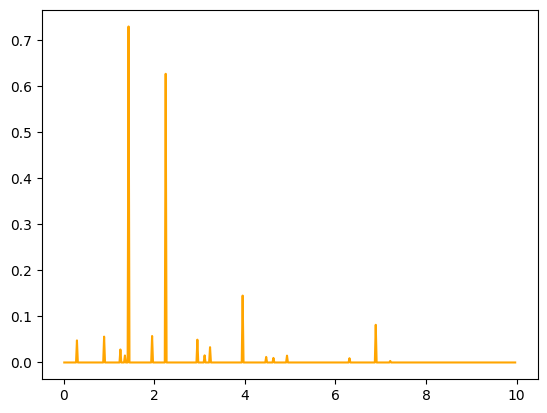

In [238]:
# Define window size
window_size = 1
kernel = np.ones(window_size) / window_size
print(len(diff_0))
smoothed_diff_0 = np.convolve(diff_0, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities, smoothed_diff_0, color="orange", label="state = 0")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

499
(499,) torch.Size([499])


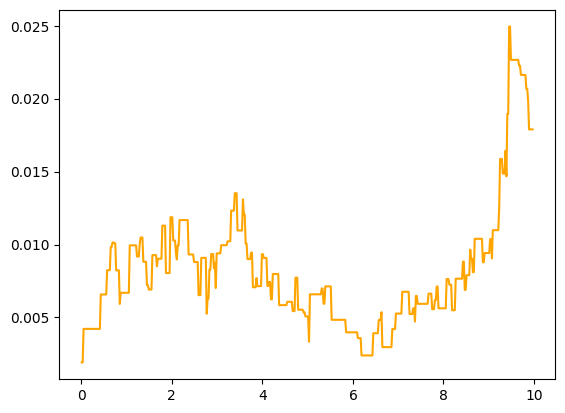

In [164]:
# Define window size
window_size = 40
kernel = np.ones(window_size) / window_size
print(len(diff_0))
smoothed_diff_0 = np.convolve(diff_0, kernel, mode='same')
print(smoothed_diff_0.shape, middle_sensitivities.shape)

plt.plot(middle_sensitivities, smoothed_diff_0, color="orange", label="state = 0")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

499


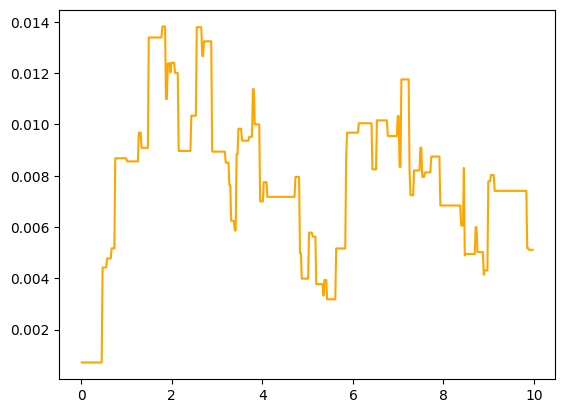

In [155]:
# Define window size
window_size = 70
kernel = np.ones(window_size) / window_size
print(len(diff_0))
smoothed_diff_0 = np.convolve(diff_0, kernel, mode='same')

plt.plot(middle_sensitivities, smoothed_diff_0, color="orange", label="state = 0")
#plt.plot(middle_sensitivities, diff_1, label="0")
#plt.plot(middle_sensitivities, diff_2)

In [17]:
diff_0 = [values_4_state_0[i, :, :, :-1] - values_4_state_0[i, :, :, 1:] for i in range(3)]

In [18]:
import torch

def moving_average(time_series, window_size=20):
    # Initialize the list with zeros for the first 100 elements
    averaged_series = [0] * min(window_size, len(time_series))
    
    # Compute the moving average for each position in the series
    for i in range(window_size, len(time_series)):
        # Calculate the average of the last 100 elements from the current position
        average = (sum(time_series[i-window_size:i]) / window_size)
        if type(average) == type(torch.tensor([0])):
            average = average.item()
        averaged_series.append(average)
    
    return averaged_series

(3, 5000, 1)


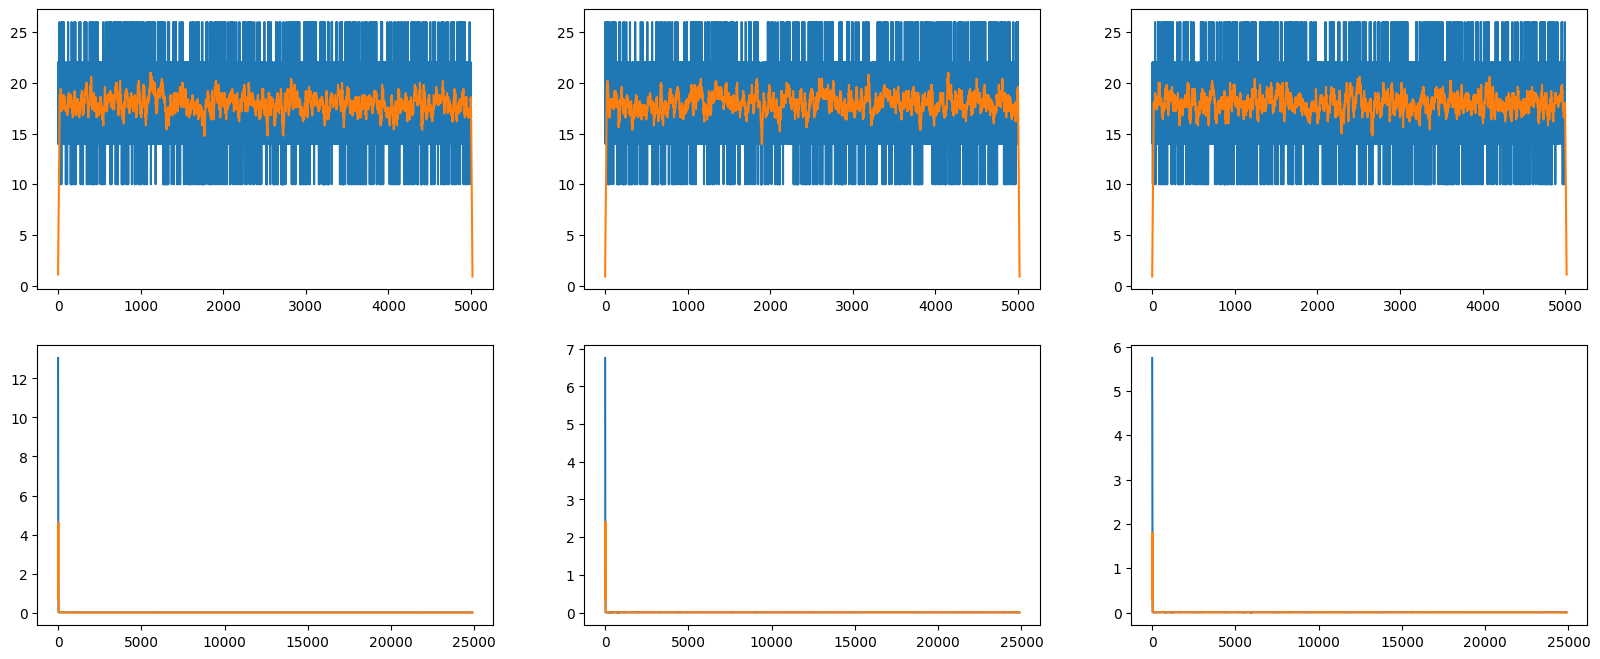

In [43]:
import numpy as np
import matplotlib.pyplot as plt

rewards_arr = np.load("reward_laplace.npy")
losses_arr = np.load("losses_laplace.npy", allow_pickle=True)
losses_arr[losses_arr==-1] = 0
# unpacking the elements of losses that are numpy arrays
#losses = [loss[0] for loss in losses]

n = losses_arr.shape[0]
fig, axes = plt.subplots(2, n, figsize=(20,8))

print(rewards_arr.shape)


for i in range(rewards_arr.shape[0]):
    rewards = rewards_arr[i]
    losses = losses_arr[i]

    window_size = 20
    kernel = np.ones(window_size) / window_size
    reward_average = np.convolve(rewards.squeeze(), kernel, mode='full')

    axes[0, i].plot(rewards)
    axes[0, i].plot(reward_average)
    
    loss_average = np.convolve(losses.squeeze(), kernel, mode='full')
    axes[1, i].plot(losses)
    axes[1, i].plot(loss_average)


plt.show()

(3, 5000, 1)


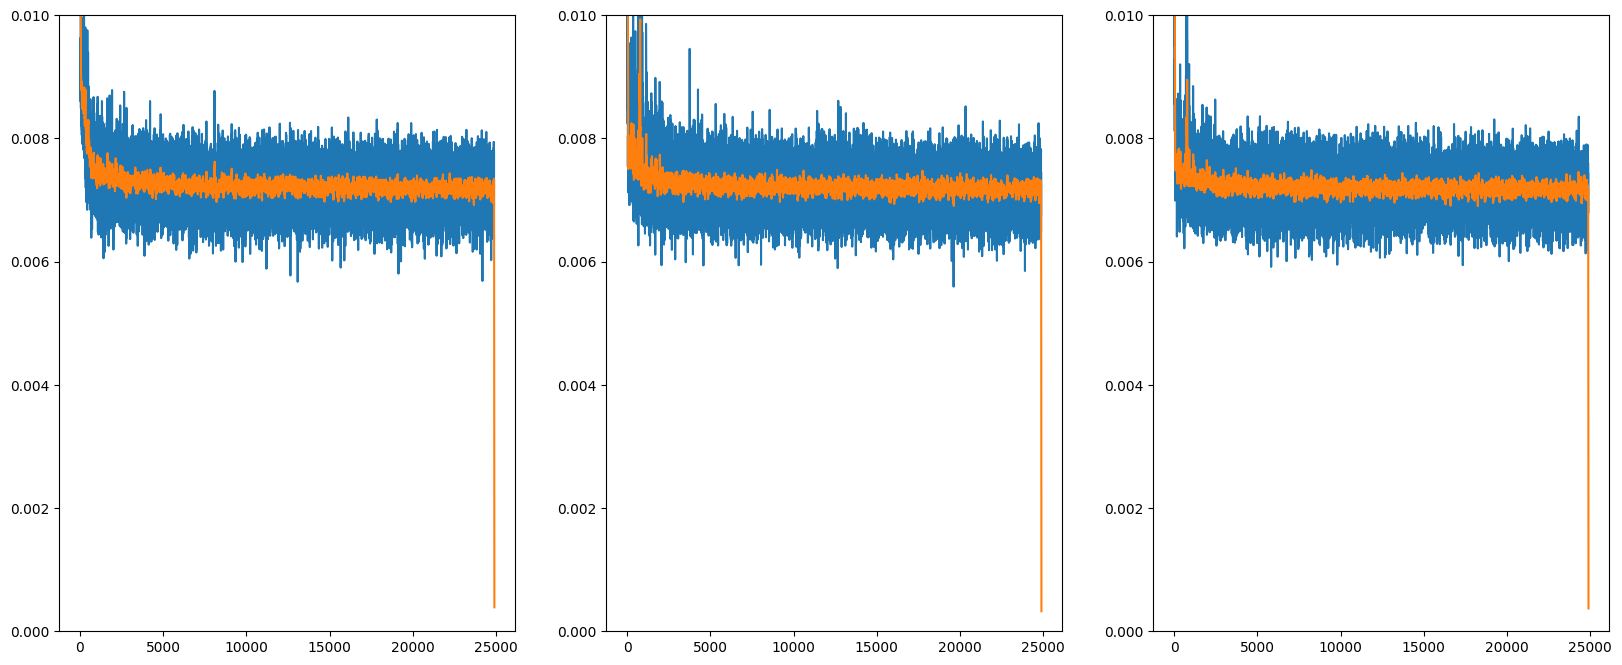

In [47]:
import numpy as np
import matplotlib.pyplot as plt

rewards_arr = np.load("reward_laplace.npy")
losses_arr = np.load("losses_laplace.npy", allow_pickle=True)
losses_arr[losses_arr==-1] = 0
# unpacking the elements of losses that are numpy arrays
#losses = [loss[0] for loss in losses]

n = losses_arr.shape[0]
fig, axes = plt.subplots(1, n, figsize=(20,8))

print(rewards_arr.shape)

common_ylim = (0, 0.01)  # Assuming your values are within this range, adjust as needed

for i in range(rewards_arr.shape[0]):
    rewards = rewards_arr[i]
    losses = losses_arr[i]

    window_size = 20
    kernel = np.ones(window_size) / window_size
    reward_average = np.convolve(rewards.squeeze(), kernel, mode='full')

    # axes[0, i].plot(rewards)
    # axes[0, i].plot(reward_average)
    
    loss_average = np.convolve(losses.squeeze(), kernel, mode='full')
    axes[i].plot(losses)
    axes[i].plot(loss_average)
    
    # Set common x and y limits
    axes[i].set_ylim(common_ylim)

plt.show()